In [1]:
#XGBoost/LightGBM – Moscatelli et al. (2022)
!pip install pandas matplotlib seaborn plotly  fredapi
!pip install interpret scikit-learn
!pip install xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
fred = Fred(api_key='e956a3dbccd7d4f90be734f8d55b1d07')
data = fred.get_series('UNRATE')
data = data.reset_index()
data.columns = ['date', 'unrate']
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
print(df.head())

        date  unrate
0 1948-01-01     3.4
1 1948-02-01     3.8
2 1948-03-01     4.0
3 1948-04-01     3.9
4 1948-05-01     3.5


In [25]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers


In [26]:
print("Outlier Detection Results (Before Model Training):")
for feature in df.columns:
    outliers = detect_outliers(df, feature)
    print(f"\nOutliers in {feature}: {len(outliers)} outliers found")
    if not outliers.empty:
        print(outliers.head())

Outlier Detection Results (Before Model Training):

Outliers in date: 0 outliers found

Outliers in unrate: 11 outliers found
417    10.4
418    10.8
419    10.8
420    10.4
421    10.4
Name: unrate, dtype: float64

Outliers in lag_1: 11 outliers found
418    10.4
419    10.8
420    10.8
421    10.4
422    10.4
Name: lag_1, dtype: float64

Outliers in lag_2: 11 outliers found
419    10.4
420    10.8
421    10.8
422    10.4
423    10.4
Name: lag_2, dtype: float64

Outliers in lag_3: 11 outliers found
420    10.4
421    10.8
422    10.8
423    10.4
424    10.4
Name: lag_3, dtype: float64

Outliers in rolling_mean: 7 outliers found
418    10.433333
419    10.666667
420    10.666667
421    10.533333
868    10.800000
Name: rolling_mean, dtype: float64

Outliers in rolling_std: 62 outliers found
13    0.351188
14    0.351188
16    0.568624
17    0.493288
21    0.700000
Name: rolling_std, dtype: float64


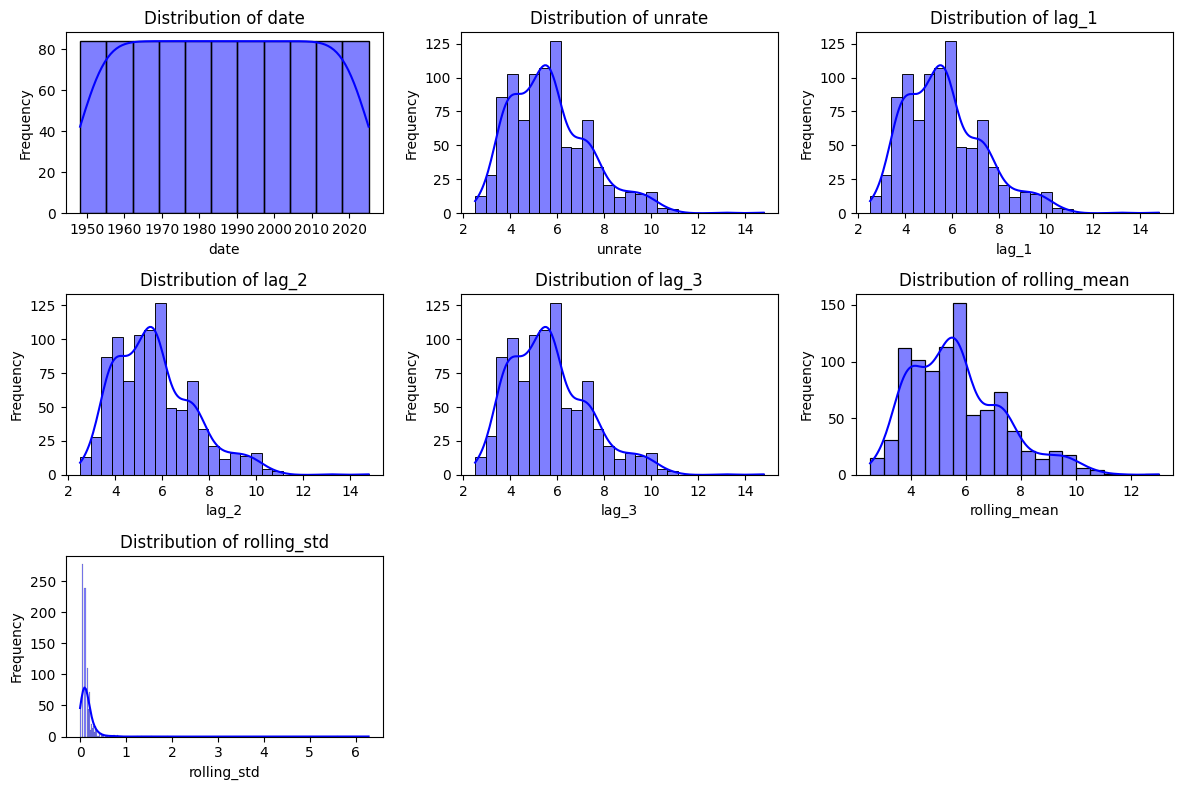

In [28]:
plt.figure(figsize=(12, 8))
num_cols = len(df.columns)
num_rows = (num_cols + 2) // 3

for i, feature in enumerate(df.columns, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(df[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('feature_histograms.png')

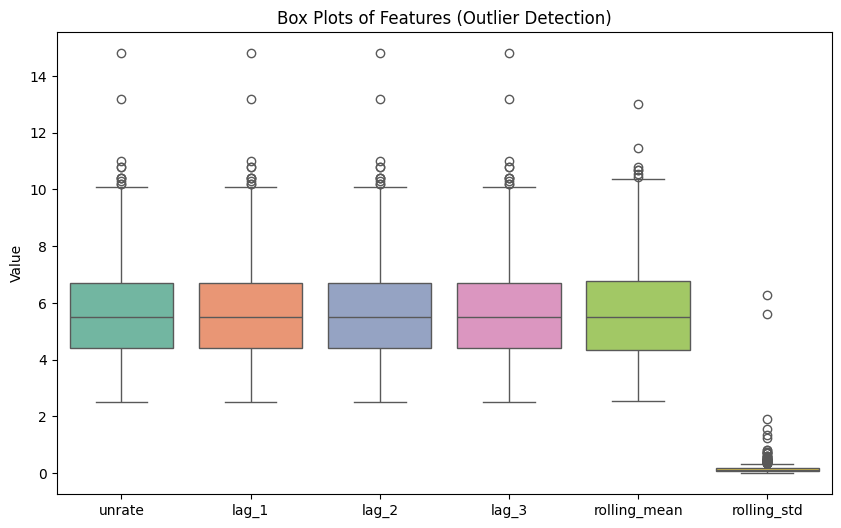

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, palette='Set2')
plt.title('Box Plots of Features (Outlier Detection)')
plt.ylabel('Value')
plt.savefig('feature_boxplots.png')


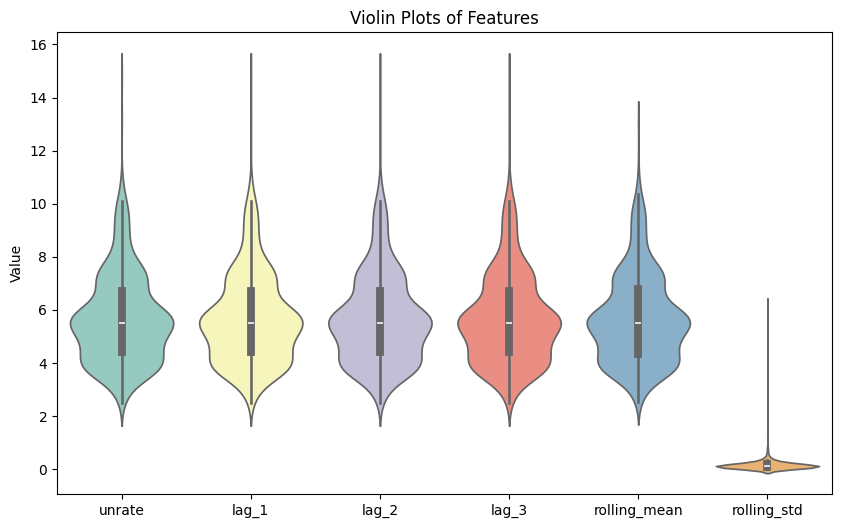

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, palette='Set3')
plt.title('Violin Plots of Features')
plt.ylabel('Value')
plt.savefig('feature_violinplots.png')

In [3]:
def create_features(df, target_col, lags=3):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df['rolling_mean'] = df[target_col].rolling(window=3).mean()
    df['rolling_std'] = df[target_col].rolling(window=3).std()
    return df

In [4]:
df = create_features(df, 'unrate', lags=3)
df = df.dropna()

Text(0, 0.5, 'Count')

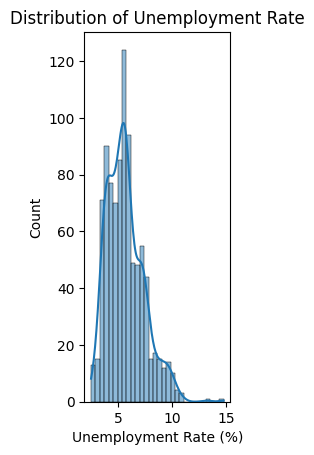

In [5]:
plt.subplot(1, 3, 1)
sns.histplot(data['unrate'], bins=30, kde=True)
plt.title('Distribution of Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Count')

In [6]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [7]:
numerical_cols = ['unrate', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std']
corr_matrix = df[numerical_cols].corr()

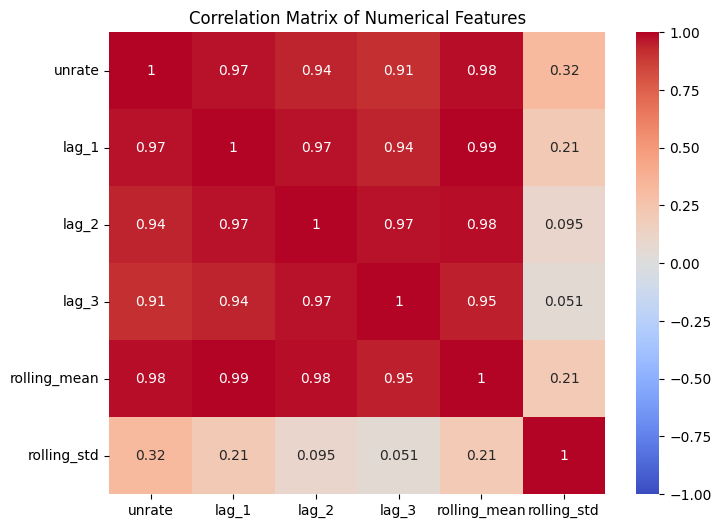

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [9]:
X = df[['lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std']]
y = df['unrate']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
print(X_train.shape, X_test.shape)

(739, 5) (185, 5)


In [12]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
y_pred = model.predict(X_test)


In [14]:
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


RMSE: 0.5966
MAE: 0.1669


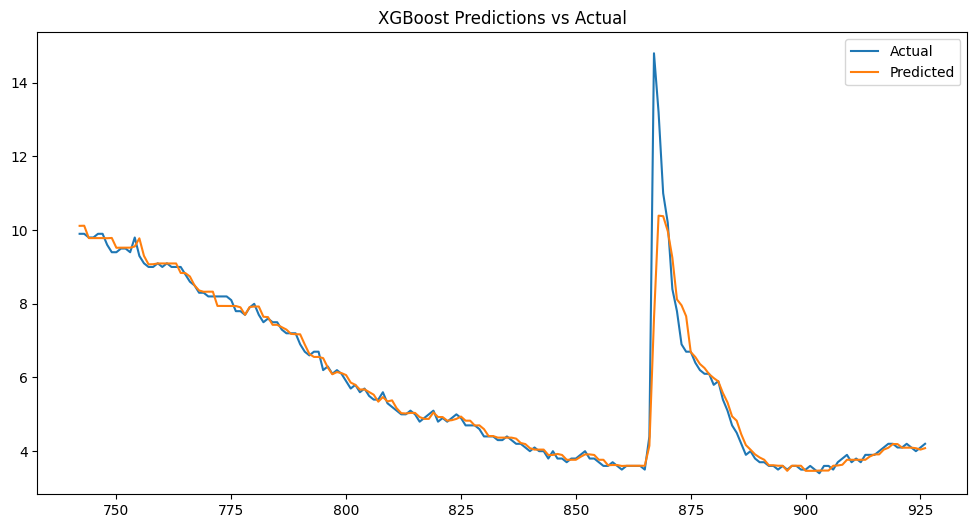

In [15]:

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('XGBoost Predictions vs Actual')
plt.legend()
plt.show()

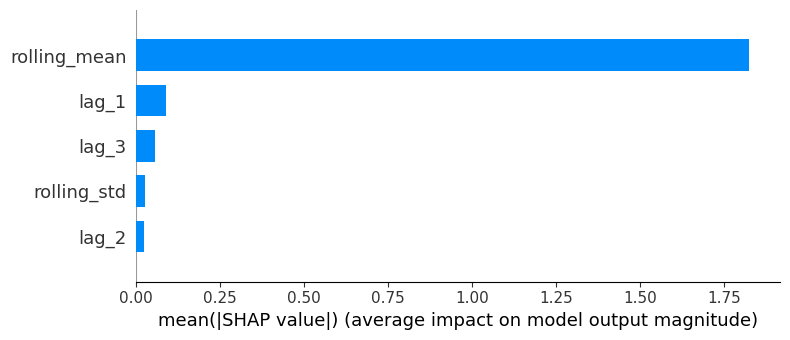

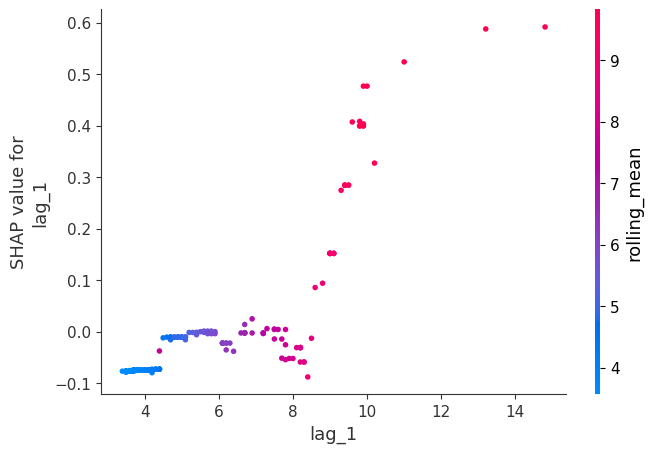

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.dependence_plot('lag_1', shap_values, X_test)

In [17]:
import lightgbm as lgb
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 739, number of used features: 5
[LightGBM] [Info] Start training from score 5.651962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor(max_depth=3, random_state=42)

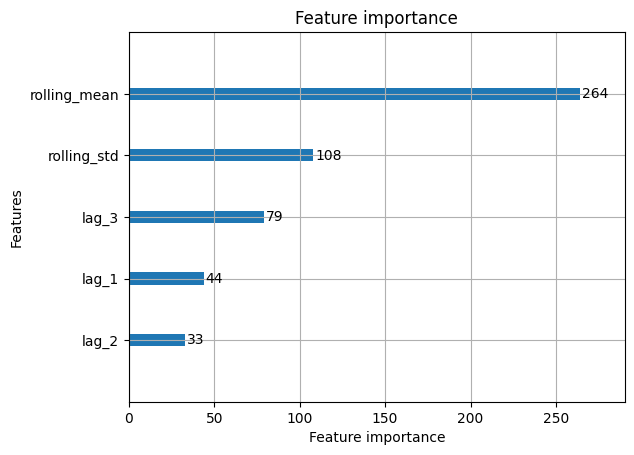

In [18]:
lgb.plot_importance(model)
plt.show()